# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

Apply Topic Modeling to Analyze a corpus of Amazon reviews

- Load in the Amazon Review dataset
- Clean the dataset 
- Vectorize the dataset 
- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end

In [ ]:
!pip install pyLDAvis==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 19.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=fbfcc27aa6a18000fdce76ab8b13b524c4c59dabe62cb9b739df0a5376fb7426
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=0bdf2877afc7f182f4aaf370ad054c1c6d95443bf0a3e485907afd7f53e79feb
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [ ]:
!pip install pandarallel==1.4.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandarallel: filename=pandarallel-1.4.8-py3-none-any.whl size=16113 sha256=5e8c8f7cd2e2acab8db5128a57c4e1faa5af55b82af18e758fccfcb3521609f2
  Stored in directory: /root/.cache/pip/wheels/fa/a4/97/5f3f33137c2bc074597dc087e21a0f47d7727874dc87e1ed37
Successfully built pandarallel


In [ ]:
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 455 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## Restart runtime!

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


----
### Load the Amazon Review corpus 
This dataset is located in the Sprint 1 Module 1 `/data` directory. 

If the provided relative path doesn't work for you, then you'll have to provide the file path so pandas can read in the file.

In [ ]:
# A "brute force" way to get the Amazon reviews dataset; just clone the Sprint 1 repo!
# Overkill, but it does the job!
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git

Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1693, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1693 (delta 89), reused 124 (delta 72), pack-reused 1531
Receiving objects: 100% (1693/1693), 59.40 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [ ]:
!unzip '/content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip'

Archive:  /content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


In [ ]:
data_path = "/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(data_path)

In [ ]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


----

### Clean data

- Create a function called `clean_data` that uses regex expressions to clean your data in preparation for the vectorizer. 

- Save the clean text data to a column in your dataframe named `clean_text`

- Feel free to re-use old code that you have written in previous modules  

In [ ]:
df.shape

(28332, 24)

In [ ]:
df['reviews.text'][8505]

'Have had zero issues with longevity or voltage. As good as the major brand batteries'

In [ ]:
import spacy
nlp = spacy.load("en_core_web_md")

def clean_data(text):
  """
  Cleans data to remove unwanted characters and punctuation.
  """
 # YOUR CODE HERE
  tokens = []
  doc = nlp(text)
  for token in doc:
    if (not token.is_punct) and (not token.is_stop) and (not token.is_digit) and (not token.like_num) and (token.lemma_.strip()!= "") and len(token.lemma_.strip())>1:
      tokens.append(token.lemma_.strip())
  return tokens


In [ ]:
# create a clean_text column by applying  clean_data to your text
df['clean_text'] = df['reviews.text'].apply(clean_data)

In [ ]:
alphebetical_chars = ["ABCDEFGHIJKLMNOP"]
# check if any of these alphabetical chars exist in your clean chars
assert df.clean_text.isin(alphebetical_chars).sum() == 0, "Did you case normalize your text inside of your clean_data function?"

------

## Determine number of topics

We are going to run an experiment to determine how many topics exists within the `primaryCategories` of `Electronics`. This is the largest primary category containing nearly 14K documents, so we should have plenty of data. 

Just as we did in the guided project, we'll be running a gridseach over the number of topics and scoring each model using the Coherence metric to determine which number of topics we should use. 


In [ ]:
# create a mask for docs that are in the Electronics primaryCategories - save result to `electronics_mask`
electronics_mask = df.primaryCategories.isin(["Electronics"])

# use mask to select all the documents in the Electronics primaryCategories - save result to `df_electronics`
df_electronics = df[electronics_mask]

In [ ]:
df_electronics.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
8343,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,Great case to keep everything in its place! My...,Excellent product,qs341_5,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,"[great, case, place, husband, love, hold, lot,..."
8344,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,http://www.amazon.co.uk/gp/product-reviews/B00...,After discarding and getting rid of broken cd ...,It was a much needed storage,Diablita,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,"[discard, getting, rid, broken, cd, case, brea..."
8345,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,"A few dollars more, but I am boycotting amazon",it was worth it,coldbloodblazing,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,"[dollar, boycott, amazon]"


------
### Tokenize your documents 

Remember that you'll need to use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class from the Gensim library. So definitely check out the docs to learn more about this tool. There is an example on how to do this in the guided project.

But before we can use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class, we must first tokenize our articles. 



In [ ]:
# identify how many processors your machine has - save the result to `n_processors`
n_processors = 1
# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# initialize just like we did in the guided project


# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
# load in the spaCy language model
nlp = spacy.load("en_core_web_md")

NameError: ignored

In [ ]:
%%time
# create our tokens in the form of lemmas 
df_electronics['lemmas'] = df_electronics['clean_text']#.apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

### Use the corpora class to prep your data for LDA

You'll need to create the same `id2word` and `corpus` objects that we created in the guided projects. So be sure to reference the guided project notebook if you need to. 

In [ ]:
# Create lemma dictionary using Dictionary - save result to `id2word`
id2word = corpora.Dictionary(df_electronics['lemmas'])
id2word.filter_extremes(no_below=2, no_above=0.5)
# Create Term Document Frequency list - save result to `corpus`
corpus = [id2word.doc2bow(doc_lemmas) for doc_lemmas in df_electronics.lemmas]

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
corpus[10]

[(44, 1),
 (47, 2),
 (67, 1),
 (96, 2),
 (118, 1),
 (120, 1),
 (127, 1),
 (162, 1),
 (178, 1),
 (180, 1),
 (181, 1),
 (182, 1),
 (183, 1),
 (184, 1),
 (185, 1),
 (186, 1),
 (187, 1),
 (188, 1),
 (189, 1),
 (190, 1),
 (191, 1),
 (192, 1),
 (193, 1)]

In [ ]:
#df_electronics['lemmas']


## Gridsearch the number of topics 

Just as we did in the guided project, we're going to run a `for` loop over a range of possible number of topics and then plot the `coherence_values` to determine which number of topics leads to the most sensible grouping of documents. 

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=2, limit=16, step=2)

CPU times: user 3min 26s, sys: 12.7 s, total: 3min 39s
Wall time: 5min 25s


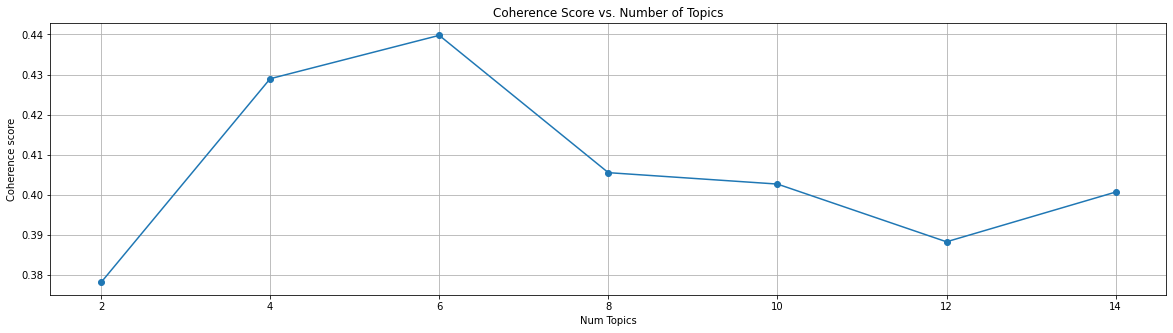

In [ ]:
start=2; limit=16;  step=2;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [ ]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`

# use `max_coherence_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`

max_coherence_val_index = 5

lda_trained_model = model_list[5]

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
pprint(lda_trained_model.print_topics())

Pretty printing has been turned ON


## Use pyLDAvis to visualize your topics 

Take a look at the topic bubbles and bar chart for the terms on the right hand side.  

- Describe the topic bubbles. 
- Do they overlap or not? 
- What does it mean when they overlap? 
- What does it mean when they don't overlap?
- Are the terms in each topic distinct from the topics in the other topic bubbles?


In [ ]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# plot your topics here -- using pyLDAvis
# YOUR CODE HERE
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_trained_model, corpus, id2word)
vis
#raise NotImplementedError()

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.047434 -0.175782       1        1  14.670347
9     -0.110296 -0.097494       2        1  11.347737
2     -0.069732 -0.103822       3        1   9.960351
1      0.272174  0.146297       4        1   9.064643
10     0.217141 -0.039941       5        1   8.575977
5     -0.025837 -0.248382       6        1   8.447274
4     -0.155590  0.221082       7        1   7.948168
3      0.142030  0.182232       8        1   7.216546
7      0.203414 -0.097826       9        1   6.956162
0     -0.158436  0.147923      10        1   5.992252
8     -0.109442 -0.034211      11        1   5.145882
6     -0.157991  0.099923      12        1   4.674661, topic_info=        Term         Freq        Total Category  logprob  loglift
215      use  3349.000000  3349.000000  Default  30.0000  30.0000
571   tablet  6407.000000  6407.000000  Default  29.0000  29.0000
67      easy  2524.000000  2524.000000  Default  28.0000  28.0000
85       old  1993.000000  1993.000000  Default  27.0000  27.0000
6       love  4384.000000  4384.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
862     Fire   129.716171  1362.103996  Topic12  -4.2045   0.7116
96   product   106.920002  1198.439021  Topic12  -4.3978   0.6463
2      great    99.897766  4667.241256  Topic12  -4.4657  -0.7812
630     know    73.354500   328.755950  Topic12  -4.7745   1.5630
204    enjoy    76.095807   710.880986  Topic12  -4.7378   0.8285

[683 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
130      12  0.990840   Alexa
250       1  0.084096  Amazon
250       2  0.060792  Amazon
250       3  0.156033  Amazon
250       7  0.285216  Amazon
...     ...       ...     ...
645       7  0.970729   world
113       4  0.999184    year
216       8  0.967602     yes
1100      4  0.996904   young
1232     10  0.995022      yr

[966 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 10, 3, 2, 11, 6, 5, 4, 8, 1, 9, 7])

## Create a Topic id/name dictionary 

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool. 

We'll use a function to map the the viz tool index ordering with the train LDA model ordering. 

In [ ]:
# create a dictionary 
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`

vis_topic_name_dict = {1:"tablet", 2: "kid", 3: "game" , 4: "old", 5: "love", 6: "screen size", 7: "7", 8: "8", 9:'9', 10: '10', 11: "11", 12: "12"}
# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model 
    and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids accoridng to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids accoridng to pyLDAvis tool 
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

Create a topic id/name look up dict 
that is aligned with the index ordering of the trained LDA model

In [ ]:
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

In [ ]:
print(topic_name_dict)

{11: 'tablet', 9: 'kid', 2: 'game', 1: 'old', 10: 'love', 5: 'screen size', 4: '7', 3: '8', 7: '9', 0: '10', 8: '11', 6: '12'}


## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name. 

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [ ]:
def get_topic_ids_for_docs(lda_trained_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get the index for the topic that had the highest probability, for the current document 
        max_topic_prob_ind = np.argmax(topic_probs)
        # get the corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store the most probable topic id for the current document
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [ ]:
# use get_topic_ids_for_docs to get the topic id for each doc in the corpus - save result to `doc_topic_ids`
doc_topic_ids = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a new feature in df_electronics called topic_id using `doc_topic_ids`
df_electronics['topic_id'] = doc_topic_ids

# iterate through topic_id and use the lookup dict `topic_name_dict` to assign each document a topic name
# save results to a new feature in df_electronics called `new_topic_name`
df_electronics['new_topic_name'] = [topic_name_dict[x] for x in df_electronics['topic_id']]

# YOUR CODE HERE
#raise NotImplementedError()

In [ ]:
df_electronics['new_topic_name']

8343             kid
8344          tablet
8345     screen size
8346              11
8347              10
            ...     
28327            old
28328           love
28329         tablet
28330           game
28331    screen size
Name: new_topic_name, Length: 13995, dtype: object

## Congratulations! You have created new topic names for your documents. 

In [ ]:
cols = ["reviews.text", "new_topic_name", "topic_id"]
df_electronics[cols].head(15)

,reviews.text,new_topic_name,topic_id
8343,Great case to keep everything in its place! My...,kid,9
8344,After discarding and getting rid of broken cd ...,tablet,11
8345,"A few dollars more, but I am boycotting amazon",screen size,5
8346,My initial impression of this was very good. T...,11,8
8347,Pros: Standard Echo. Cons: Older generation Ec...,10,0
8348,"Pros: Got it for under 50, much impressive sou...",11,8
8349,Pros: I love the Alexa series so when this one...,screen size,5
8350,"ASIDE FROM THE FACT THAT THE SCREEN IS SMALL, ...",tablet,11
8351,"I wasn't sure I even wanted this item, but cau...",7,4
8352,Pros: Works good like Alexia Cons: setting it ...,tablet,11


-----
# Stretch Goals -- see if you can create a model to classify the reviews into the latent topics you've discovered!


- Treat `topic_id` as the `y` (target) vector and train a supervised learning model to predict the topic of each document
- Report your results on the Slack channel!

## Topic Modeling References



- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures